In [54]:
## import lib
import pandas as pd
import numpy as np
from numpy.linalg import pinv,inv,matrix_power
from scipy.linalg import sqrtm
from scipy.io import loadmat
import itertools
import math
import csv
from matplotlib.pyplot import plot
from tqdm import tqdm

In [15]:
# load data
data_dir = './Dataset/spam_data.mat'
data = loadmat(data_dir)
tr_data = data['train_x']
ts_data = data['test_x']
tr_label = data['train_y']
ts_label = data['test_y']

tr_N = tr_data.shape[0]
feat_dim = tr_data.shape[1]
ts_N = ts_data.shape[0]
print('tr_data-shape:',tr_data.shape)
print('ts_data-shape:',ts_data.shape)
print('tr_label-shape:',tr_label.shape)
print('ts_label-shape:',ts_label.shape)

tr_data-shape: (2000, 40)
ts_data-shape: (500, 40)
tr_label-shape: (2000, 2)
ts_label-shape: (500, 2)


100%|██████████| 500/500 [00:10<00:00, 45.49it/s]


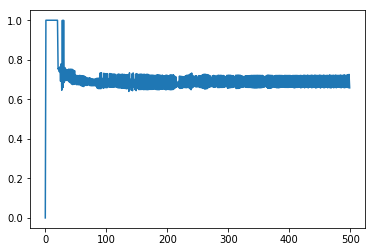

In [68]:
# Initial-Para.
W1 = np.random.randn(feat_dim, 10)
W2 = np.random.randn(10, 3)
W3 = np.random.randn(3, 2)
b1 = np.random.randn(10)
b2 = np.random.randn(3)
b3 = np.random.randn(2)
lr = 10e-4

def act_func(a_ary):
    # RELU
    a_ary[a_ary<0]=0
    return a_ary

def act_derivative(a_ary):
    # Derivative of RELU
    a_ary[a_ary<=0]=0
    a_ary[a_ary>0]=1
    return a_ary
    
def self_softmax(a_ary):
    e_x = np.exp(a_ary - np.max(a_ary))
    return e_x / e_x.sum(axis=0)

# fwd, bwd
def fwd(input_X):
    b1_mat = np.tile(b1,(tr_N,1)).T
    b2_mat = np.tile(b2,(tr_N,1)).T
    b3_mat = np.tile(b3,(tr_N,1)).T    
    a1 = np.matmul(W1.T,input_X.T) + b1_mat
    h1 = act_func(a1)
    a2 = np.matmul(W2.T,h1) + b2_mat
    h2 = act_func(a2)
    a3 = np.matmul(W3.T,h2) + b3_mat
    y_pre = self_softmax(a3)
    return a1, a2, a3, h1, h2, y_pre
    
def bwd(x,h1,h2,y_pred,a1,a2,yt_label):
    global b1,b2,b3,W1,W2,W3
    
    g = y_pred - yt_label # the result of both derivative with y & softmac-function
    
    # third-layer
    grad_b3 = np.sum(g,axis = 1)
    grad_w3 = np.matmul(g,h2.T).T
    g = np.matmul(W3,g)
    
    # second-layer
    g = (a2>0)*g
    grad_b2 = np.sum(g,axis = 1)
    grad_w2 = np.matmul(g,h1.T).T
    g = np.matmul(W2,g)
    
    # first-layer
    g = (a1>0)*g
    grad_b1 = np.sum(g,axis = 1)
    grad_w1 = np.matmul(g,x).T
    
    grad_b = [grad_b1,grad_b2,grad_b3]
    grad_w = [grad_w1,grad_w2,grad_w3]
    return grad_b, grad_w

def Check_para():
    print(b1)
    print(b2)
    print(b3)
#     print(W1)
#     print(W2)
#     print(W3)
    
def Calculate_errRate(pred, gt):
    cnt = 0
    for i in range(tr_N):
        y_pre = np.argmax(pred[:,i])
        y_gt = np.argmax(gt)
        if y_pre == y_gt:
            cnt += 1
    return cnt / tr_N
        
# main-function
# Check_para()
rms_err_lst = []
ave_cross_entropy_loss_lst = []
err_rate_lst = []
for i in tqdm(range(500)):
    a1, a2, a3, h1, h2, y_pred = fwd(tr_data)
    grad_b, grad_w = bwd(tr_data, h1, h2, y_pred, a1, a2, tr_label.T)
    ave_cross_entropy_loss = - np.sum(tr_label.T*np.log(y_pred))
    err_rate = Calculate_errRate(y_pred, tr_label.T)
    
    b1 -= lr*grad_b[0]
    b2 -= lr*grad_b[1]
    b3 -= lr*grad_b[2]
    W1 -= lr*grad_w[0]
    W2 -= lr*grad_w[1]
    W3 -= lr*grad_w[2]
    rms_err_lst.append(rms_err)
    ave_cross_entropy_loss_lst.append(ave_cross_entropy_loss)
    err_rate_lst.append(err_rate)
#     print(rms_err)

# print(rms_err)
plot(range(500), err_rate_lst)  

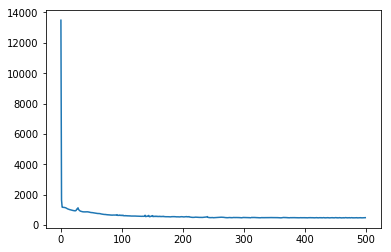

In [69]:
plot(range(500), ave_cross_entropy_loss_lst)  

In [47]:
43/2

21.5